# Data collection

In [2]:
import gymnasium as gym
import ale_py
import numpy as np
from tqdm import tqdm

# --- 설정값 ---
TOTAL_STEPS = 20000
ENV_ID = 'ALE/MontezumaRevenge-v5'

print(f"'{ENV_ID}' 환경에서 총 {TOTAL_STEPS} 스텝의 데이터를 수집합니다.")

# --- 환경 초기화 ---
env = gym.make(ENV_ID, render_mode='rgb_array')

# --- 데이터를 종류별로 저장할 리스트 생성 ---
obs_buffer = []
action_buffer = []
reward_buffer = []
terminated_buffer = []
truncated_buffer = []

observation, info = env.reset()

for _ in tqdm(range(TOTAL_STEPS)):
    action = env.action_space.sample()
    next_observation, reward, terminated, truncated, info = env.step(action)
    
    # 각 리스트에 데이터 추가
    obs_buffer.append(observation)
    action_buffer.append(action)
    reward_buffer.append(reward)
    terminated_buffer.append(terminated)
    truncated_buffer.append(truncated)
    
    if terminated or truncated:
        observation, info = env.reset()
    else:
        observation = next_observation

env.close()
print(f"\n데이터 수집 완료! 총 {len(obs_buffer)}개의 경험을 저장했습니다.")

# --- 압축된 .npz 파일로 저장 ---
np.savez_compressed(
    'data/montezuma_data1.npz',  # 파일 이름
    observations=np.array(obs_buffer, dtype=np.uint8),
    actions=np.array(action_buffer, dtype=np.int8),
    rewards=np.array(reward_buffer, dtype=np.float32),
    terminateds=np.array(terminated_buffer, dtype=np.bool_),
    truncateds=np.array(truncated_buffer, dtype=np.bool_)
)

print("✅ 'montezuma_data1.npz' 파일로 데이터 저장을 완료했습니다.")

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


'ALE/MontezumaRevenge-v5' 환경에서 총 20000 스텝의 데이터를 수집합니다.


100%|██████████| 20000/20000 [00:05<00:00, 3532.69it/s]



데이터 수집 완료! 총 20000개의 경험을 저장했습니다.
✅ 'montezuma_data1.npz' 파일로 데이터 저장을 완료했습니다.


In [1]:
import numpy as np
data = np.load('data/montezuma_data1.npz')
observations_raw = data['observations']
actions = data['actions']

# VAE training

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import optim
from PIL import Image
from torchvision import transforms
from parts.VAE_CNN import VAE, vae_loss_function, CustomImageDataset
from parts.MDN_RNN import MDN_RNN, mdn_rnn_loss
from parts.controller import controller
from tqdm.auto import tqdm

observations = torch.tensor(observations_raw).permute(0, 3, 1, 2)
vae = VAE(input_channel=3, latent_dim=256).to('cuda:0')

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()]) 

observations = CustomImageDataset(data=observations, transform=resize)

dataloader = DataLoader(dataset=observations, batch_size=512)

optimizer = optim.AdamW(vae.parameters(), lr=1e-4)

def vae_train(vae, optimizer, dataloader, epochs=10):
    vae.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, data in tqdm(enumerate(dataloader)):
            data = data.to('cuda:0')
            _, recon_image, mu, logvar = vae(data)

            loss = vae_loss_function(recon_image, data, mu, logvar, beta=0.2)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
        
        print(f'Epoch {epoch}, Everage loss: {total_loss/len(dataloader):.6f}')

vae_train(vae, optimizer, dataloader, epochs=10)


2it [00:00,  3.38it/s]

Epoch 0, Batch 0, Loss: 8241.160156


40it [00:04,  9.17it/s]


Epoch 0 완료, 평균 손실: 8219.913525


2it [00:00, 10.07it/s]

Epoch 1, Batch 0, Loss: 8195.562500


40it [00:03, 10.37it/s]


Epoch 1 완료, 평균 손실: 7885.012537


1it [00:00,  9.87it/s]

Epoch 2, Batch 0, Loss: 6561.656250


40it [00:03, 10.38it/s]


Epoch 2 완료, 평균 손실: 5513.706323


1it [00:00,  9.94it/s]

Epoch 3, Batch 0, Loss: 4593.614258


40it [00:03, 10.40it/s]


Epoch 3 완료, 평균 손실: 4229.807709


1it [00:00,  9.88it/s]

Epoch 4, Batch 0, Loss: 3947.666504


40it [00:03, 10.35it/s]


Epoch 4 완료, 평균 손실: 3800.921045


1it [00:00,  9.55it/s]

Epoch 5, Batch 0, Loss: 3641.253906


40it [00:03, 10.37it/s]


Epoch 5 완료, 평균 손실: 3510.270300


1it [00:00,  9.88it/s]

Epoch 6, Batch 0, Loss: 3328.120605


40it [00:03, 10.36it/s]


Epoch 6 완료, 평균 손실: 3177.712799


1it [00:00,  9.58it/s]

Epoch 7, Batch 0, Loss: 3017.803711


40it [00:03, 10.27it/s]


Epoch 7 완료, 평균 손실: 2931.324036


1it [00:00,  9.86it/s]

Epoch 8, Batch 0, Loss: 2821.701660


40it [00:03, 10.37it/s]


Epoch 8 완료, 평균 손실: 2769.025824


1it [00:00,  9.59it/s]

Epoch 9, Batch 0, Loss: 2687.305176


40it [00:03, 10.45it/s]

Epoch 9 완료, 평균 손실: 2657.644800


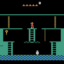

In [5]:
to_pil = transforms.ToPILImage()
to_pil(observations[0])

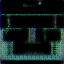

In [6]:
# latent_size 256, beta=0.2
vae.eval()
data = observations[10044].unsqueeze(0).to("cuda:0")
hidden_state, recon_image, _, _ = vae(data)
to_pil(recon_image[0])

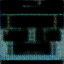

In [ ]:
# latent_size 512, beta=0.1
vae.eval()
data = observations[10012].unsqueeze(0).to("mps")
hidden_state, recon_image, _, _ = vae(data)
to_pil(recon_image[0])

# MDN-RNN traning

In [46]:
observations = torch.tensor(observations_raw).permute(0, 3, 1, 2)

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()]) 

In [2]:
import torch
from torch.utils.data import DataLoader
from torch import optim
from PIL import Image
from parts.MDN_RNN import MDN_RNN, mdn_rnn_loss, SequenceDataset
import numpy as np

action_size = int(actions.max()) + 1
action_onehot = np.eye(action_size)[actions] # np.eye is generates identity matrix

mdn_rnn = MDN_RNN(input_size=256, action_size=action_size).to('cuda:0')

seq_dataset = SequenceDataset(image_dataset=observations, transforms=resize, action_dataset=action_onehot, sequence_length=1000)
dataloader = DataLoader(dataset=seq_dataset, batch_size=8)

optimizer = optim.AdamW(mdn_rnn.parameters(), lr=1e-4)

def rnn_train(model=mdn_rnn, dataloader=dataloader, optimizer=optimizer, epochs=10):
    model.train()
    vae.eval()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (image, action) in enumerate(dataloader):
            image, action = image.to('cuda:0'), action.to('cuda:0')
            with torch.no_grad():
                # have to reshape image vector because vae(cnn) input shape is (batch_size, channel_size, height, width)
                batch, sequence, C, H, W = image.size()
                reshape_images = image.view(-1, C, H, W)
                z_vectors_flatten, _, _, _ = vae(reshape_images)
                z_vectors = z_vectors_flatten.view(batch, sequence, -1)
                
            mu, sigma, phi = model(z_vectors, action)

            batch, sequence, num_dist, latent_size = mu.size()

            mu_pred = mu[: , :-1, :].view(-1, num_dist, latent_size)
            sigma_pred = sigma[: , :-1, :].view(-1, num_dist, latent_size)
            phi_pred = phi[: , :-1, :].view(-1, num_dist)
            target_z =  z_vectors[: , 1:, :].view(-1, latent_size)

            loss = mdn_rnn_loss(mu_pred, sigma_pred, phi_pred, target_z)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"epoch: {epoch+1}, Everage loss: {total_loss/len(dataloader):.6f}")

rnn_train()

NameError: name 'actions' is not defined

In [40]:
action_size = int(actions.max()) + 1
action_onehot = np.eye(action_size)[actions] # np.eye is generates identity matrix

mdn_rnn = MDN_RNN(input_size=256, action_size=action_size).to('cuda:0')

seq_dataset = SequenceDataset(image_dataset=observations, action_dataset=action_onehot, sequence_length=1000)
dataloader = DataLoader(dataset=seq_dataset, batch_size=8)